In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from skimage import io
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from monai.networks import one_hot
from segment_anything import SamPredictor, sam_model_registry
import cv2
import random
from segment_anything.utils.transforms import ResizeLongestSide

## Functions

In [2]:
# read a folder of images and turn them into an array

def read_images_to_array(folder_path):

  image_array = []
  # Get a sorted list of filenames
  filenames = sorted(os.listdir(folder_path))
  for filename in filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
      img_path = os.path.join(folder_path, filename)
      img = cv2.imread(img_path)

      if img is not None:
        image_array.append(img)

  return image_array

def split_images(image_array): 

    red_region_images = []
    raw_images = [] 

    for image in image_array:
        if image[25,100].sum() == 255*3 :
            red_region_images.append(image)
        else: 
            raw_images.append(image) 
            
    return red_region_images, raw_images

def crop_raw_images(image_array): 
    
    cropped_images = [] 
    
    for i in range(len(image_array)): 
        
        image = image_array[i]
        
        mask = np.zeros(image.shape, dtype=np.uint8)
        mask = cv2.circle(mask, (320, 240), 200, (255,255,255), -1)

        res = cv2.bitwise_and(image, mask)
        res[mask==0] = 255
        
        cropped_images.append(res)

    return cropped_images

def crop_masks(image_array):
    cropped_masks = []

    for image in image_array:
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        mask = cv2.circle(mask, (250, 257), 135, (255, 255, 255), -1)

        if image.shape[:2] != mask.shape:
            raise ValueError("Image and mask dimensions do not match.")

        res = cv2.bitwise_and(image, image, mask=mask)
        res[mask == 0] = 255

        cropped_masks.append(res)

    return cropped_masks

def create_binary_masks(image_array):
    binary_masks = []
    
    for image in image_array:
        # Ensure image is in BGR format (convert if necessary)
        if image.ndim == 2:
            # Convert grayscale to BGR color (assuming gray image)
            image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        elif image.shape[2] != 3:
            raise ValueError("Input image must have 3 channels (BGR format).")
        else:
            image_color = image
        
        # Convert BGR to HSV
        hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

        # Define lower and upper bounds for red color in HSV
        lower_red = np.array([0, 150, 115])
        upper_red = np.array([255, 255, 255])

        # Create mask using inRange function
        mask = cv2.inRange(hsv, lower_red, upper_red)

        # Apply bitwise AND operation using color image
        res = cv2.bitwise_and(image_color, image_color, mask=mask)
        
        binary_masks.append(mask)
        
    return binary_masks

def create_blank_masks(image_array): 
    masks = []
    for i in range(len(image_array) - 1): 
        mask = np.zeros((256, 256), dtype=np.uint8)  # Create a 2D array filled with zeros
        masks.append(mask)
    return masks

def zoom_at(image_array, zoom, coord=None):
    
    zoomed_array = []
    
    for img in image_array: 
        

        # Translate to zoomed coordinates
        h, w, _ = [ zoom * i for i in img.shape ]

        if coord is None: cx, cy = w/2, h/2
        else: cx, cy = [ zoom*c for c in coord ]

        img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
        img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
                   int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5)),
                   : ]
        zoomed_array.append(img)
    
    return zoomed_array

def double_crop(image_array): 
    
    cropped_images = []
    
    for image in image_array: 
        
        # this is crop for each side (totalCrop/2) 
        cropped_image = image[0:515, 70:570]
        
        cropped_images.append(cropped_image)
    
    return cropped_images

def add_padding(image_array): 
    
    padded_images = []
    
    for image in image_array: 

        padded_image = cv2.copyMakeBorder(
            image,
            17,
            17,
            0,
            0,
            cv2.BORDER_CONSTANT,
            value=(255,255,255)
        )
        
        padded_images.append(padded_image)
        
    return padded_images


In [3]:
# function to resize images

def crop_images(image_array): 
    
    cropped_images = []
    
    for i in range(len(image_array) -1): 
        
        image = image_array[i]
        
        image_height, image_width = image.shape[:2]
        
        # Bounding box dimensions
        box_width, box_height = 256, 256

        x_top_left = (image_width - box_width) // 2
        y_top_left = (image_height - box_height) // 2
        x_bottom_right = x_top_left + box_width
        y_bottom_right = y_top_left + box_height
        
        cropped_image = image[y_top_left:y_bottom_right, x_top_left:x_bottom_right]
        cropped_images.append(cropped_image)
                              
    return cropped_images 

In [4]:
# function to create blank masks 

def create_blank_masks(image_array): 
    masks = []
    for i in range(len(image_array)): 
        mask = np.zeros((256, 256), dtype=np.uint8)  # Create a 2D array filled with zeros
        masks.append(mask)
    return masks

In [5]:
# get bounding box, if its empty, then create a random sized bounding box  

def get_bounding_box(image_mask):
    
    if np.all(image_mask == 0):
        # If all zeros, create a random bounding box
        H, W = image_mask.shape
        x_min = np.random.randint(0, W)
        x_max = np.random.randint(x_min + 1, W + 1)  # Ensure x_max > x_min
        y_min = np.random.randint(0, H)
        y_max = np.random.randint(y_min + 1, H + 1)  # Ensure y_max > y_min
        
        bbox = [x_min, y_min, x_max, y_max]
    else: 
        if len(image_mask.shape) == 2 or image_mask.shape[2] == 1:
            gray = image_mask
        else:
            gray = cv2.cvtColor(image_mask, cv2.COLOR_BGR2GRAY)

        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return (0, 0, 0, 0)
        
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        bbox = [x, y, x+w, y+h]
    
    return bbox

## Apply Functions

In [6]:
# get images
folder_path_training = './data/training_images'
train_images = read_images_to_array(folder_path_training)
folder_path_val = './data/val_images'
val_images = read_images_to_array(folder_path_val)
folder_path_empty = './data/images_wo_tumor'
ntumor_images = read_images_to_array(folder_path_empty)

# split them 
train_masks, train_raw = split_images(train_images)
val_masks, val_raw = split_images(val_images) 

# crop each one out 
train_raw = crop_raw_images(train_raw) 
val_raw = crop_raw_images(val_raw) 
train_masks = crop_masks(train_masks)
val_masks = crop_masks(val_masks) 

# create masks for images with no tumors 
ntumor_masks = create_blank_masks(ntumor_images) 

# zoom masks
train_masks = zoom_at(train_masks, 1.4, coord=None)
val_masks = zoom_at(val_masks, 1.4, coord=None)

# create binary masks
train_masks = create_binary_masks(train_masks)
val_masks = create_binary_masks(val_masks) 

# crop raw images 
train_raw = double_crop(train_raw)
val_raw = double_crop(val_raw) 

# add padding to raw images 
train_raw = add_padding(train_raw) 
val_raw = add_padding(val_raw) 

# resize images to 256x256 
train_raw = crop_images(train_raw) 
train_masks = crop_images(train_masks) 

val_raw = crop_images(val_raw) 
val_masks = crop_images(val_masks) 

ntumor_images = crop_images(ntumor_images) 
ntumor_masks = crop_images(ntumor_masks) 

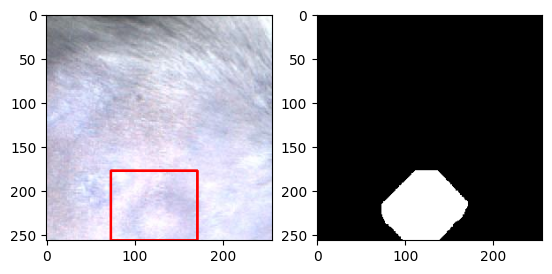

In [7]:
# Test bounding box function
rand = random.randint(0, len(train_raw) - 1)

# Get the bounding box for the selected mask
bbox = get_bounding_box(train_masks[rand])

# Plot the images
fig, ax = plt.subplots(1, 2)

# Create a copy of the raw image to draw the rectangle on
copy_image = train_raw[rand].copy()

# Draw the bounding box on the image
cv2.rectangle(copy_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

# Display the images
ax[0].imshow(copy_image)
ax[1].imshow(train_masks[rand], cmap="gray")
plt.show()


In [8]:
train_masks = np.array(train_masks)
train_raw = np.array(train_raw) 

val_masks = np.array(val_masks)
val_raw = np.array(val_raw) 

print(train_masks.shape)
print(train_raw.shape)
print(val_masks.shape)
print(val_raw.shape) 

(153, 256, 256)
(153, 256, 256, 3)
(36, 256, 256)
(36, 256, 256, 3)


## Augmentation

In [9]:
# Augmentation function 

def augment_image_array(image_array_raw, image_array_binary, num_augmentations):
    aug_raw = []
    aug_masks = []
    
    for _ in range(num_augmentations):
            for i in range(len(image_array_raw) -1):
                image_raw = image_array_raw[i]
                image_binary = image_array_binary[i]

                flipped_image_raw = cv2.flip(image_raw, 1)
                flipped_image_binary = cv2.flip(image_binary, 1)

                # Random angle
                angle = random.uniform(-30, 30)
                (h, w) = flipped_image_raw.shape[:2]
                center = (w // 2, h // 2)

                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                augmented_image_raw = cv2.warpAffine(flipped_image_raw, M, (w, h))
                augmented_image_binary = cv2.warpAffine(flipped_image_binary, M, (w, h))

                aug_raw.append(augmented_image_raw)
                aug_masks.append(augmented_image_binary)

    # Extend original arrays with augmented data
    image_array_raw = np.concatenate((image_array_raw, np.array(aug_raw)))
    image_array_binary = np.concatenate((image_array_binary, np.array(aug_masks)))

    return image_array_raw, image_array_binary

In [10]:
# apply augmentation to all images

train_raw, train_masks = augment_image_array(train_raw, train_masks, 50) 
val_raw, val_masks = augment_image_array(val_raw, val_masks, 50) 
ntumor_images, ntumor_masks = augment_image_array(ntumor_images, ntumor_masks, 20)

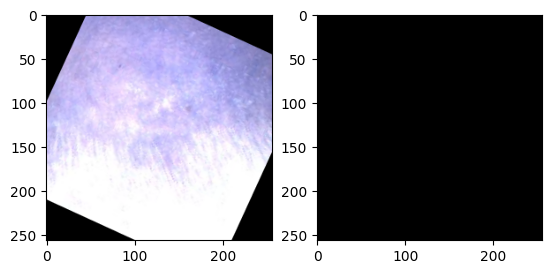

In [11]:
# test no tumor images

rand = random.randint(0, len(ntumor_images) -1) 

fig, ax = plt.subplots(1,2) 

ax[0].imshow(ntumor_images[rand])
ax[1].imshow(ntumor_masks[rand], cmap="gray")

plt.show()

In [12]:
print(train_raw.shape)
print(train_masks.shape) 
print(val_raw.shape) 
print(val_masks.shape) 

print(ntumor_images.shape)
print(ntumor_masks.shape)

(7753, 256, 256, 3)
(7753, 256, 256)
(1786, 256, 256, 3)
(1786, 256, 256)
(841, 256, 256, 3)
(841, 256, 256)


In [13]:
# now add them to the orignal arrays 
train_raw = np.concatenate((train_raw, ntumor_images), axis=0)
train_masks = np.concatenate((train_masks, ntumor_masks), axis=0)

In [14]:
print(train_raw.shape)
print(train_masks.shape) 

(8594, 256, 256, 3)
(8594, 256, 256)


## Create Dataset

In [16]:
# now create a dataset with these images

from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
training_dataset_dict = {
    "image": [Image.fromarray(img) for img in train_raw],
    "label": [Image.fromarray(mask) for mask in train_masks],
}

val_dataset_dict = {
    "image": [Image.fromarray(img) for img in val_raw],
    "label": [Image.fromarray(mask) for mask in val_masks],
}

In [17]:
# Create the dataset using the datasets.Dataset class
training_dataset = Dataset.from_dict(training_dataset_dict)
val_dataset = Dataset.from_dict(val_dataset_dict)

In [30]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [32]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("./models/MedSAM_checkpoint/sam_vit_b_01ec64.pth")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 64: invalid start byte

In [24]:
from torch.utils.data import random_split, DataLoader

training_dataset = SAMDataset(dataset=training_dataset, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset, processor=processor)

train_dataloader = DataLoader(dataset=training_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=False) 

In [ ]:
from PIL import Image

def save_images(image_array, folder_path, base_name='image', format='png'):

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    for idx, img_array in enumerate(image_array):
        img = Image.fromarray(img_array)
        img.save(os.path.join(folder_path, f"{base_name}_{idx}.{format}"))

In [25]:
def train_model(trainloader,valloader,dir_checkpoint,epochs):
    if args.if_warmup:
        b_lr = args.lr / args.warmup_period
    else:
        b_lr = args.lr
    
    sam = sam_model_registry[args.arch](args,checkpoint=os.path.join(args.sam_ckpt),num_classes=args.num_cls)
    if args.finetune_type == 'adapter':
        for n, value in sam.named_parameters():
            if "Adapter" not in n: # only update parameters in adapter
                value.requires_grad = False
        print('if update encoder:',args.if_update_encoder)
        print('if image encoder adapter:',args.if_encoder_adapter)
        print('if mask decoder adapter:',args.if_mask_decoder_adapter)
        if args.if_encoder_adapter:
            print('added adapter layers:',args.encoder_adapter_depths)
        
    elif args.finetune_type == 'vanilla' and args.if_update_encoder==False:   
        print('if update encoder:',args.if_update_encoder)
        for n, value in sam.image_encoder.named_parameters():
            value.requires_grad = False
    elif args.finetune_type == 'lora':
        print('if update encoder:',args.if_update_encoder)
        print('if image encoder lora:',args.if_encoder_lora_layer)
        print('if mask decoder lora:',args.if_decoder_lora_layer)
        sam = LoRA_Sam(args,sam,r=4).sam
    sam.to('cuda')
        
    optimizer = optim.AdamW(sam.parameters(), lr=b_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
    optimizer.zero_grad()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) #learning rate decay
    criterion1 = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, to_onehot_y=True,reduction='mean')
    criterion2 = nn.CrossEntropyLoss()
    
    iter_num = 0
    max_iterations = epochs * len(trainloader) 
    writer = SummaryWriter(dir_checkpoint + '/log')
    
    pbar = tqdm(range(epochs))
    val_largest_dsc = 0
    last_update_epoch = 0
    for epoch in pbar:
        sam.train()
        train_loss = 0
        for i,data in enumerate(tqdm(trainloader)):
            imgs = data['image'].cuda()
            msks = torchvision.transforms.Resize((args.out_size,args.out_size))(data['mask'])
            msks = msks.cuda()

            if args.if_update_encoder:
                img_emb = sam.image_encoder(imgs)
            else:
                with torch.no_grad():
                    img_emb = sam.image_encoder(imgs)
            
            # get default embeddings
            sparse_emb, dense_emb = sam.prompt_encoder(
                points=None,
                boxes=None,
                masks=None,
            )
            pred, _ = sam.mask_decoder(
                            image_embeddings=img_emb,
                            image_pe=sam.prompt_encoder.get_dense_pe(), 
                            sparse_prompt_embeddings=sparse_emb,
                            dense_prompt_embeddings=dense_emb, 
                            multimask_output=True,
                          )
            loss_dice = criterion1(pred,msks.float()) 
            loss_ce = criterion2(pred,torch.squeeze(msks.long(),1))
            loss =  loss_dice + loss_ce
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            
            if args.if_warmup and iter_num < args.warmup_period:
                lr_ = args.lr * ((iter_num + 1) / args.warmup_period)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_

            else:
                if args.if_warmup:
                    shift_iter = iter_num - args.warmup_period
                    assert shift_iter >= 0, f'Shift iter is {shift_iter}, smaller than zero'
                    lr_ = args.lr * (1.0 - shift_iter / max_iterations) ** 0.9  # learning rate adjustment depends on the max iterations
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = lr_

            train_loss += loss.item()
            iter_num+=1
            writer.add_scalar('info/lr', lr_, iter_num)
            writer.add_scalar('info/total_loss', loss, iter_num)
            writer.add_scalar('info/loss_ce', loss_ce, iter_num)
            writer.add_scalar('info/loss_dice', loss_dice, iter_num)

        train_loss /= (i+1)
        pbar.set_description('Epoch num {}| train loss {} \n'.format(epoch,train_loss))

        if epoch%2==0:
            eval_loss=0
            dsc = 0
            sam.eval()
            with torch.no_grad():
                for i,data in enumerate(tqdm(valloader)):
                    imgs = data['image'].cuda()
                    msks = torchvision.transforms.Resize((args.out_size,args.out_size))(data['mask'])
                    msks = msks.cuda()

                    img_emb= sam.image_encoder(imgs)
                    sparse_emb, dense_emb = sam.prompt_encoder(
                        points=None,
                        boxes=None,
                        masks=None,
                    )
                    pred, _ = sam.mask_decoder(
                                    image_embeddings=img_emb,
                                    image_pe=sam.prompt_encoder.get_dense_pe(), 
                                    sparse_prompt_embeddings=sparse_emb,
                                    dense_prompt_embeddings=dense_emb, 
                                    multimask_output=True,
                                  )
                    loss = criterion1(pred,msks.float()) + criterion2(pred,torch.squeeze(msks.long(),1))
                    eval_loss +=loss.item()
                    dsc_batch = dice_coeff_multi_class(pred.argmax(dim=1).cpu(), torch.squeeze(msks.long(),1).cpu().long(),args.num_cls)
                    dsc+=dsc_batch

                eval_loss /= (i+1)
                dsc /= (i+1)
                
                writer.add_scalar('eval/loss', eval_loss, epoch)
                writer.add_scalar('eval/dice', dsc, epoch)
                
                print('Eval Epoch num {} | val loss {} | dsc {} \n'.format(epoch,eval_loss,dsc))
                if dsc>val_largest_dsc:
                    val_largest_dsc = dsc
                    last_update_epoch = epoch
                    print('largest DSC now: {}'.format(dsc))
                    torch.save(sam.state_dict(),dir_checkpoint + '/checkpoint_best.pth')
                elif (epoch-last_update_epoch)>20:
                    # the network haven't been updated for 20 epochs
                    print('Training finished###########')
                    break
    writer.close()

In [ ]:
# save images to file
save_images(train_raw, './data/testing_folder', base_name='image', format='png')

In [27]:
train_model(train_dataloader,val_dataloader,'./models/MedSAM_checkpoint/sam_vit_b_01ec64.pth',1)
            
            
            
            

NameError: name 'args' is not defined

In [25]:
from skimage import io

data_tr_path = './data'

# pre-compute image image embedding
names = sorted(os.listdir(join(data_tr_path, 'testing_folder')))

for name in tqdm(names):
    image_data = io.imread(join(data_tr_path, 'testing_folder', name))
    if image_data.shape[-1]>3 and len(image_data.shape)==3:
        image_data = image_data[:,:,:3]
    if len(image_data.shape)==2:
        image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    resize_img = sam_transform.apply_image(image_data)
    resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
    input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
    assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'
    # pre-compute the image embedding
    with torch.no_grad():
        embedding = sam_model.image_encoder(input_image)
        # save the image embedding
        np.save(join(embed_tr_path, name.split('.png')[0]+'.npy'), embedding.cpu().numpy()[0])

  0%|          | 0/8594 [00:00<?, ?it/s]


NameError: name 'sam_model' is not defined

In [26]:
# now create a dataset with these images

from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
training_dataset_dict = {
    "image": [img for img in train_masks],
    "label": [mask for mask in train_masks ],
}

val_dataset_dict = {
    "image": [img for img in val_raw],
    "label": [mask for mask in val_masks],
}

In [27]:
print(len(val_dataset_dict["image"]))
print(len(val_dataset_dict["label"]))

print(len(training_dataset_dict["image"]))
print(len(training_dataset_dict["label"]))

1786
1786
8594
8594


In [28]:
# Create the dataset using the datasets.Dataset class
training_dataset = Dataset.from_dict(training_dataset_dict)
val_dataset = Dataset.from_dict(val_dataset_dict)

In [32]:
from torch.utils.data import random_split, DataLoader

train_dataloader = DataLoader(dataset=training_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=False) 

In [47]:
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Ensure the images and masks are in the correct format
        if len(image.shape) == 2:
            image = np.repeat(image[:, :, None], 3, axis=-1)

        if image.shape[-1] > 3:
            image = image[:, :, :3]

        if self.transform:
            image = self.transform(image)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask

# Example usage
transform = None  # Add any required transforms here

train_dataset = CustomDataset(train_raw, train_masks, transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


In [48]:
# set the work directory
work_dir = './models/MedSAM_finetuned'
task_name = 'AutoSegDemo2D'
model_save_path = join(work_dir, task_name)

os.makedirs(model_save_path, exist_ok=True)

optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide

In [50]:
model_type = 'vit_b'
checkpoint = './models/MedSAM_checkpoint/sam_vit_b_01ec64.pth'
device = 'cuda:0'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)

In [51]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from os.path import join

num_epochs = 100
best_loss = 1e10
sam_model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for step, (image_embedding, gt) in enumerate(tqdm(train_dataloader)):
        # Ensure image_embedding and gt are tensors
        image_embedding = image_embedding.to(device)
        gt = gt.to(device)

        print(f"Step {step}: image_embedding shape = {image_embedding.shape}, gt shape = {gt.shape}")

        # Check dimensions of ground truth masks and resize if necessary
        if gt.shape[2:] != (256, 256):
            gt = F.interpolate(gt, size=(256, 256), mode='nearest')
            print(f"Resized gt to shape = {gt.shape}")

        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            B, _, H, W = gt.shape
            # set the bbox as the image size for fully automatic segmentation
            boxes = torch.from_numpy(np.array([[0, 0, 256, 256]] * B)).float().to(device)
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=boxes[:, None, :],
                masks=None,
            )
        
        # Predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding,  # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
            multimask_output=False,
        )

        # Check dimensions of mask_predictions
        print(f"mask_predictions shape = {mask_predictions.shape}")

        # Ensure mask_predictions and gt have the same dimensions
        if mask_predictions.shape[2:] != gt.shape[2:]:
            mask_predictions = F.interpolate(mask_predictions, size=gt.shape[2:], mode='nearest')
            print(f"Resized mask_predictions to shape = {mask_predictions.shape}")

        loss = seg_loss(mask_predictions, gt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # Save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
    # Save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))


  0%|          | 0/4 [00:10<?, ?it/s]

Step 0: image_embedding shape = torch.Size([32, 3, 512, 512]), gt shape = torch.Size([32, 512, 512])


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [512] and output size of (256, 256). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.